### Python Implementation

In [343]:
import warnings
warnings.filterwarnings(action='ignore')

In [344]:
#importing packages
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import requests
import io
from datetime import datetime
import math

### Importing Data

In [345]:
#download the data
url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv"
download = requests.get(url).content
df = pd.read_csv(io.StringIO(download.decode('utf-8')))

state = "Maine"

#subset Maine data & reset index
df_state = df[df.state == state]

#estimate, April 1, 2020, https://www.census.gov/quickfacts/fact/table/ME/PST040221#PST040221
N = 1362359 



In [346]:
df_state.reset_index(inplace=True,drop=True)
df_state.loc[:,'recovered']= df_state.sort_values(by='date')['cases'].shift(14)
df_state['recovered'].fillna(0, inplace=True)
df_state['removed'] = df_state['recovered']+df_state['deaths']
df_state['infected'] = df_state['cases'] - df_state['removed']
df_state

,date,state,fips,cases,deaths,recovered,removed,infected
0,2020-03-12,Maine,23,1,0,0.0,0.0,1.0
1,2020-03-13,Maine,23,2,0,0.0,0.0,2.0
2,2020-03-14,Maine,23,3,0,0.0,0.0,3.0
3,2020-03-15,Maine,23,12,0,0.0,0.0,12.0
4,2020-03-16,Maine,23,17,0,0.0,0.0,17.0
...,...,...,...,...,...,...,...,...
768,2022-04-19,Maine,23,240086,2276,236709.0,238985.0,1101.0
769,2022-04-20,Maine,23,240810,2277,236985.0,239262.0,1548.0
770,2022-04-21,Maine,23,241249,2278,237218.0,239496.0,1753.0
771,2022-04-22,Maine,23,241716,2280,237481.0,239761.0,1955.0


# Exploratory Data Analysis

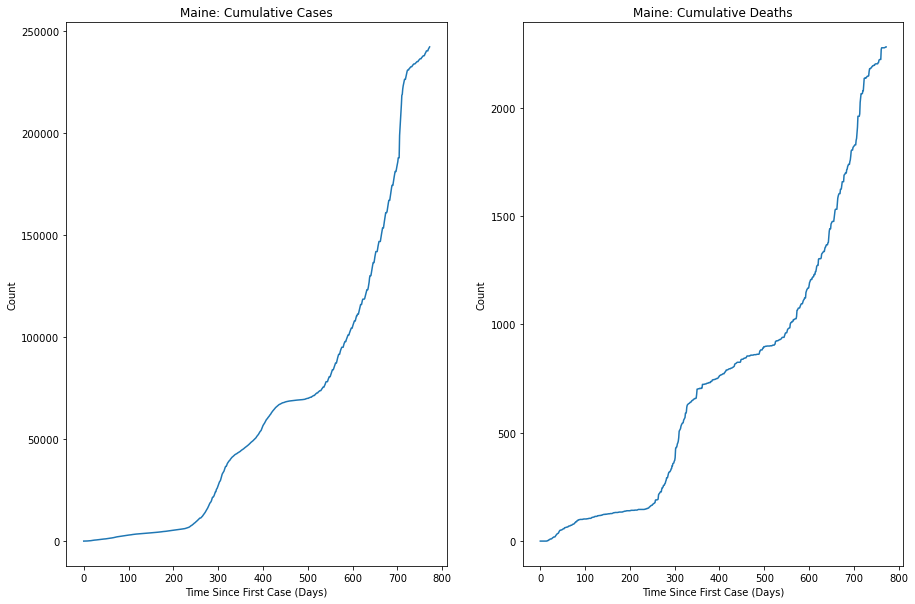

In [347]:
#plotting cases and deaths 
fig = plt.figure(figsize=(15,10))

plt.subplot(1, 2, 1) 
plt.plot(df_state.index, df_state['cases'])
plt.xlabel("Time Since First Case (Days)")
plt.ylabel("Count")
plt.title(state+": Cumulative Cases")

plt.subplot(1, 2, 2)
plt.plot(df_state.index, df_state['deaths'])
plt.xlabel("Time Since First Case (Days)")
plt.ylabel("Count")
plt.title(state + ": Cumulative Deaths")

plt.show()


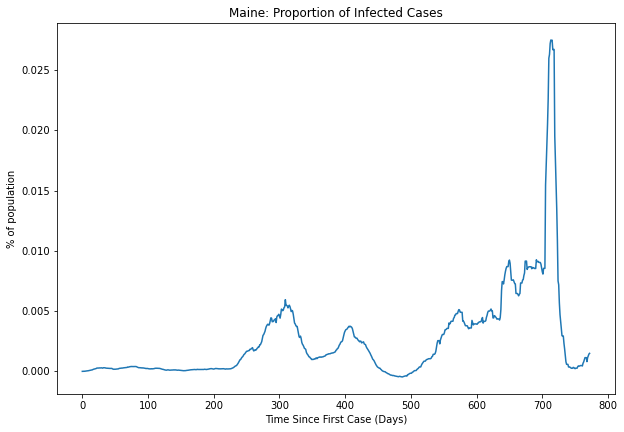

In [348]:
fig = plt.figure(figsize=(10,15))
ax1 = plt.subplot(2, 1, 1)
plt.plot(df_state.index, df_state['infected']/N)
plt.xlabel("Time Since First Case (Days)")
plt.ylabel("% of population")
plt.title(state +": Proportion of Infected Cases")
plt.show()

# Model Specification - SIR

In [349]:
### Fixed Parameters ###

#Initial Number of infected and recovered, I0 and R0
I0, R0 = 1, 0 


# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0 

#number of days to compute
t = np.linspace(0, len(df_state)-1, len(df_state)) 

### Parameters to Vary ###

#recovery rate (recovery probability within one time step)
#average illness duration of 14 days
gamma = 1./14 


In [350]:
# The SIR model differential equations.
def deriv_dynamic(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta(t) * S * I / N
    dIdt = beta(t) * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

### Smooth $R_0$ Transition

$$R_0(t) = \frac{R_0^{start} - R_0^{end}}{1 + e^{-k(-x+x_0)}} + R_0^{end}$$

$R_0^{start}$ and $R_0^{end}$ are the starting and ending $R_0$ values that we want to interpolate between. 

$x_0$ is the inflection point of the transition, i.e., the day that $R_0$ changes most dramatically. 

$k$ describes how fast R_0 change. Larger $k$ means faster change.

In [351]:
epochs = [0,20,200, 300,320, 380, 416, 476]


R_0 = [5, 2.5, 1.15, 1.5,.7, 1.1,.9, .89, 1.3]
k=0.1

#https://www.maine.gov/covid19/timeline
# 4 - march 15,2020 - declared a Civil State of Emergency
#21 -  march 31, 2020 - Stay Healthy at Home directive
#223 - October 20, 2020 
#308 - January 13 - first-doses vaccinations 
#328 - Feb 2, 2021
#382  - march 28, 2021
#467 - May 1, 2021 - first stage of re-opening 
#567 - June 30, 2021 - state of civil emergency ends
x = [4, 21, 233, 308,328, 382, 416, 476]


def R_0_dynamic(t):
    value = None
    for i in range(len(epochs)):
        if t >= epochs[i]:
            value = logistic_R_0(t, k, x[i], R_0[i],  R_0[i+1])
    return value

def logistic_R_0(t, k, x, start, end):
    return (start - end) / (1 + np.exp(-k * (-t + x))) + end

def beta_dynamic(t):
    return R_0_dynamic(t) * gamma
# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv_dynamic, y0, t, args = (N, beta_dynamic, gamma))
S, I, R = ret.T

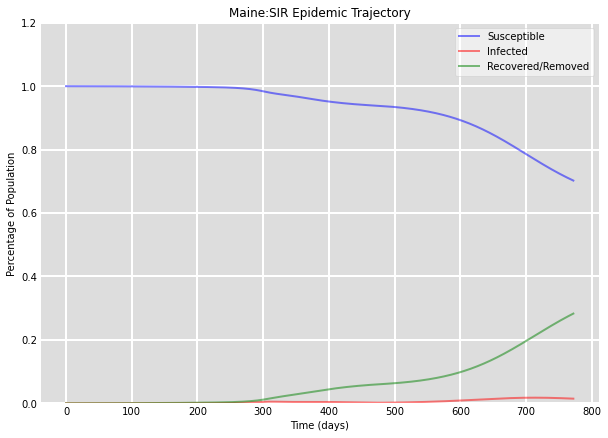

In [352]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/N, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/N, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/N, 'g', alpha=0.5, lw=2, label='Recovered/Removed')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Percentage of Population')
ax.set_title(state+':SIR Epidemic Trajectory')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

Text(0.5, 1.0, 'Maine: Proportion of Infected Cases')

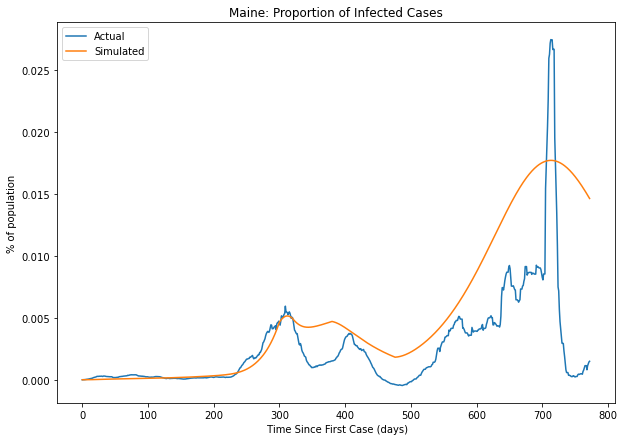

In [353]:
fig = plt.figure(figsize=(10,7))
plt.plot(df_state.index,df_state['infected']/N,label="Actual")
plt.plot(df_state.index, I/N,label="Simulated")
plt.legend()
plt.xlabel(" Time Since First Case (days)")
plt.ylabel("% of population")
plt.title(state + ": Proportion of Infected Cases")

# Calculating Errors

In [354]:
#calculate error 
def rms(actual,simulated,T):
    error=np.sqrt(np.sum(np.square(actual-simulated)/T))
    print(error)

In [355]:
def eabs(actual, simulated, T):
    error=np.sum(np.abs(actual-simulated)/T)
    print(error)

In [356]:

actual = df_state['infected']
simulated = I

rms(actual, simulated, len(t))
eabs(actual, simulated, len(t))

6756.193659048987
3984.2075048995343


# Part 2

In [357]:
#source: data from https://www.healthdata.org/covid/data-downloads

#import data
data20 = pd.read_csv("data_download_file_reference_2020.csv")
data21 = pd.read_csv("data_download_file_reference_2021.csv")
data22 = pd.read_csv("data_download_file_reference_2022.csv")




estimates = pd.read_csv("estimates.csv")

In [358]:
#subset data for desired state
subset20 = data20[data20.location_name == state]
#getting data to start at 3/12/2020
subset20 = subset20.iloc[37:]
subset21 = data21[data21.location_name == state]
#getting data to end at 4/23/2022
subset22 = data22[data22.location_name == state]
subset22 = subset22.iloc[0:113]

subset = pd.concat([subset20, subset21, subset22])
subset.reset_index(inplace=True,drop=True)
subset

#https://covidestim.org/
estimates_state = estimates[estimates.state == state]
#getting data to start at 3/12/2020
estimates_state = estimates_state.iloc[33:]
estimates_state.reset_index(inplace=True,drop=True)
estimates_state

,state,date,cases.fitted,cases.fitted.hi,cases.fitted.lo,cum.incidence,cum.incidence.hi,cum.incidence.lo,deaths,deaths.diagnosed,...,severe,severe.hi,severe.lo,symptomatic,symptomatic.diagnosed,symptomatic.diagnosed.hi,symptomatic.diagnosed.lo,symptomatic.hi,symptomatic.lo,data.available
0,Maine,2020-03-12,2.061538,NaN,NaN,2.411732e+02,6.117481e+02,96.008665,0.018258,0.016394,...,0.171858,NaN,NaN,14.582891,2.849417,NaN,NaN,NaN,NaN,True
1,Maine,2020-03-13,2.619802,NaN,NaN,2.968327e+02,7.278290e+02,122.620709,0.023573,0.021174,...,0.216702,NaN,NaN,17.956964,3.584442,NaN,NaN,NaN,NaN,True
2,Maine,2020-03-14,3.300496,NaN,NaN,3.624030e+02,8.606783e+02,154.920213,0.030240,0.027173,...,0.271185,NaN,NaN,21.917044,4.466756,NaN,NaN,NaN,NaN,True
3,Maine,2020-03-15,4.120109,NaN,NaN,4.388674e+02,1.011468e+03,193.661505,0.038538,0.034643,...,0.336727,NaN,NaN,26.509376,5.511384,NaN,NaN,NaN,NaN,True
4,Maine,2020-03-16,5.093965,NaN,NaN,5.271300e+02,1.181205e+03,239.589705,0.048779,0.043866,...,0.414777,NaN,NaN,31.769477,6.730304,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,Maine,2022-02-23,2785.235173,NaN,NaN,1.064543e+06,1.192566e+06,940186.033095,19.319558,17.568470,...,174.725782,NaN,NaN,6891.187362,2407.635834,NaN,NaN,NaN,NaN,True
714,Maine,2022-02-24,2605.762145,NaN,NaN,1.073220e+06,1.198538e+06,950372.660584,19.921538,18.125428,...,175.233243,NaN,NaN,6627.244943,2150.554410,NaN,NaN,NaN,NaN,True
715,Maine,2022-02-25,2377.538721,NaN,NaN,1.081112e+06,1.204573e+06,959791.856419,20.477874,18.637610,...,174.761343,NaN,NaN,6323.519278,1861.179018,NaN,NaN,NaN,NaN,True
716,Maine,2022-02-26,2110.992872,NaN,NaN,1.088224e+06,1.209563e+06,967897.323503,20.975010,19.091746,...,173.268324,NaN,NaN,5985.314680,1556.854338,NaN,NaN,NaN,NaN,True


In [359]:
#obtaining values for estimated R_0
rt = []

for i in t:
    rt.append(R_0_dynamic(i))

len(rt)


773

## Mobility

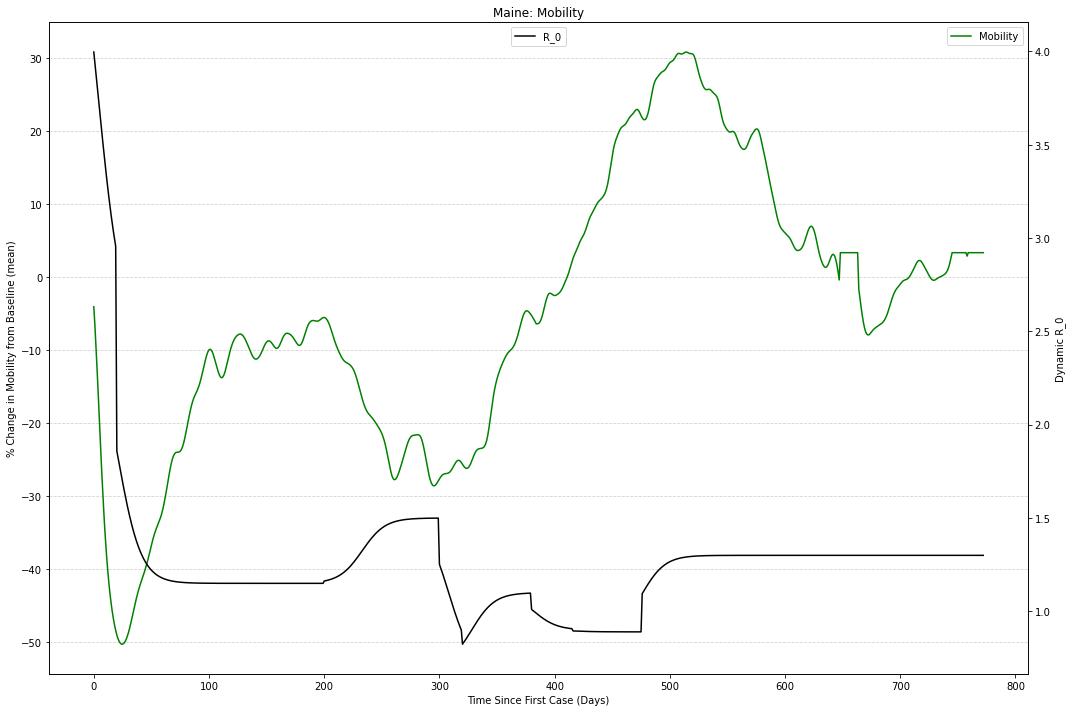

In [360]:

fig, ax = plt.subplots(figsize=(15,10))
ax2 = ax.twinx()
ax.set_title(state+': Mobility')
ax.set_xlabel('Time Since First Case (Days)')
ax.plot(subset.index, subset['mobility_mean'], color='green')
#ax2.scatter(estimates_state.index, estimates_state['Rt'], color='black')
ax.set_ylabel('% Change in Mobility from Baseline (mean)')
ax2.set_ylabel('Dynamic R_0')
ax2.plot(t, rt, color='black')
ax.legend(['Mobility'])
ax2.legend(['R_0'], loc='upper center')
ax.yaxis.grid(color='lightgray', linestyle='dashed')
plt.tight_layout()
plt.show()

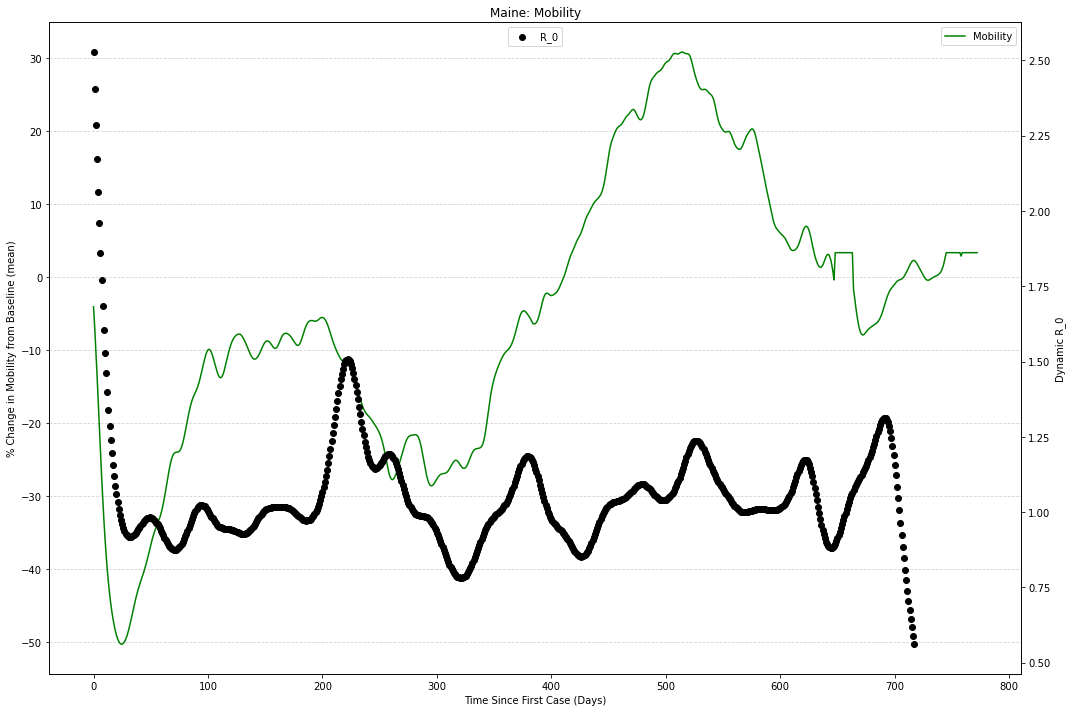

In [361]:
fig, ax = plt.subplots(figsize=(15,10))
ax2 = ax.twinx()
ax.set_title(state+': Mobility')
ax.set_xlabel('Time Since First Case (Days)')
ax.plot(subset.index, subset['mobility_mean'], color='green')
ax2.scatter(estimates_state.index, estimates_state['Rt'], color='black')
ax.set_ylabel('% Change in Mobility from Baseline (mean)')
ax2.set_ylabel('Dynamic R_0')
#ax2.plot(t, rt, color='black')
ax.legend(['Mobility'])
ax2.legend(['R_0'], loc='upper center')
ax.yaxis.grid(color='lightgray', linestyle='dashed')
plt.tight_layout()
plt.show()

## Mask Use

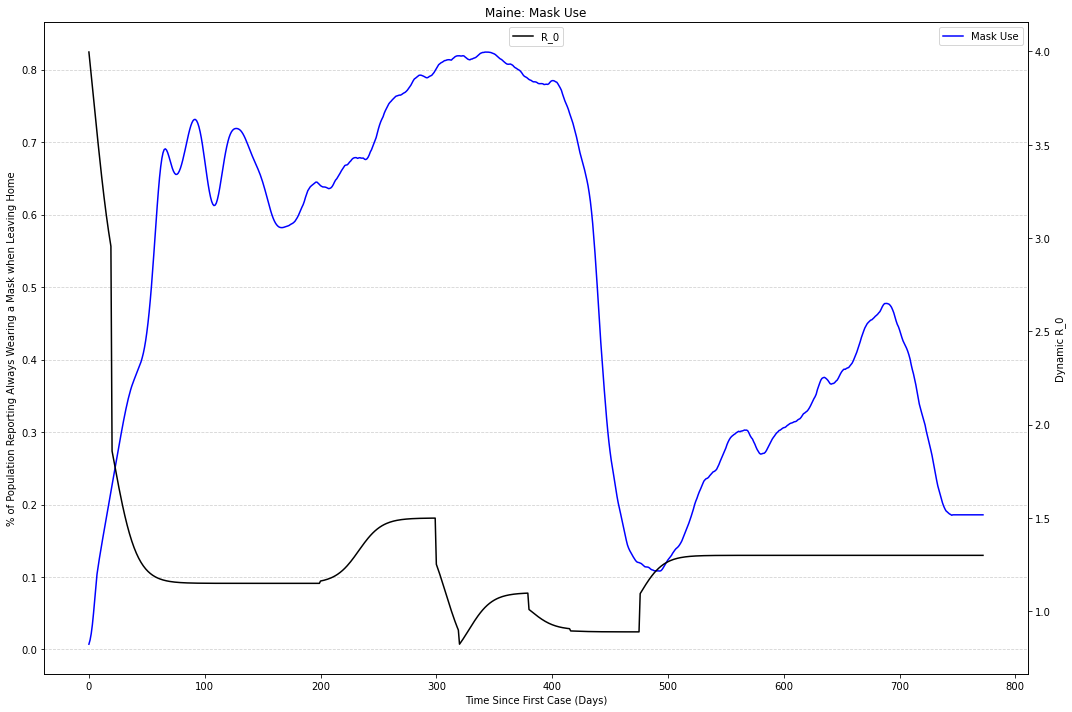

In [362]:

fig, ax = plt.subplots(figsize=(15,10))
ax2 = ax.twinx()
ax.set_title(state+': Mask Use')
ax.set_xlabel('Time Since First Case (Days)')
ax.plot(subset.index, subset['mask_use_mean'], color='blue')
ax2.plot(t, rt, color='black')
ax.set_ylabel('% of Population Reporting Always Wearing a Mask when Leaving Home')
ax2.set_ylabel('Dynamic R_0')
ax.legend(['Mask Use'])
ax2.legend(['R_0'], loc='upper center')
ax.yaxis.grid(color='lightgray', linestyle='dashed')
plt.tight_layout()
plt.show()

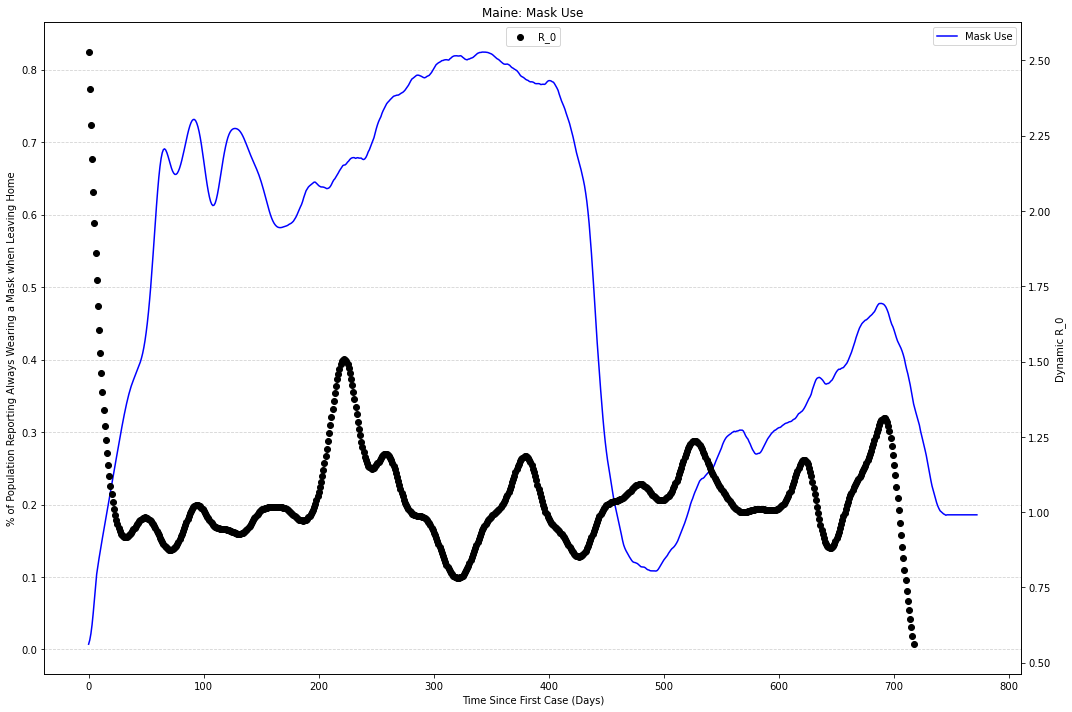

In [363]:

fig, ax = plt.subplots(figsize=(15,10))
ax2 = ax.twinx()
ax.set_title(state+': Mask Use')
ax.set_xlabel('Time Since First Case (Days)')
ax.plot(subset.index, subset['mask_use_mean'], color='blue')
#ax2.plot(t, rt, color='black')
ax.set_ylabel('% of Population Reporting Always Wearing a Mask when Leaving Home')
ax2.set_ylabel('Dynamic R_0')
ax2.scatter(estimates_state.index, estimates_state['Rt'], color='black')
ax.legend(['Mask Use'])
ax2.legend(['R_0'], loc='upper center')
ax.yaxis.grid(color='lightgray', linestyle='dashed')
plt.tight_layout()
plt.show()

## Testing

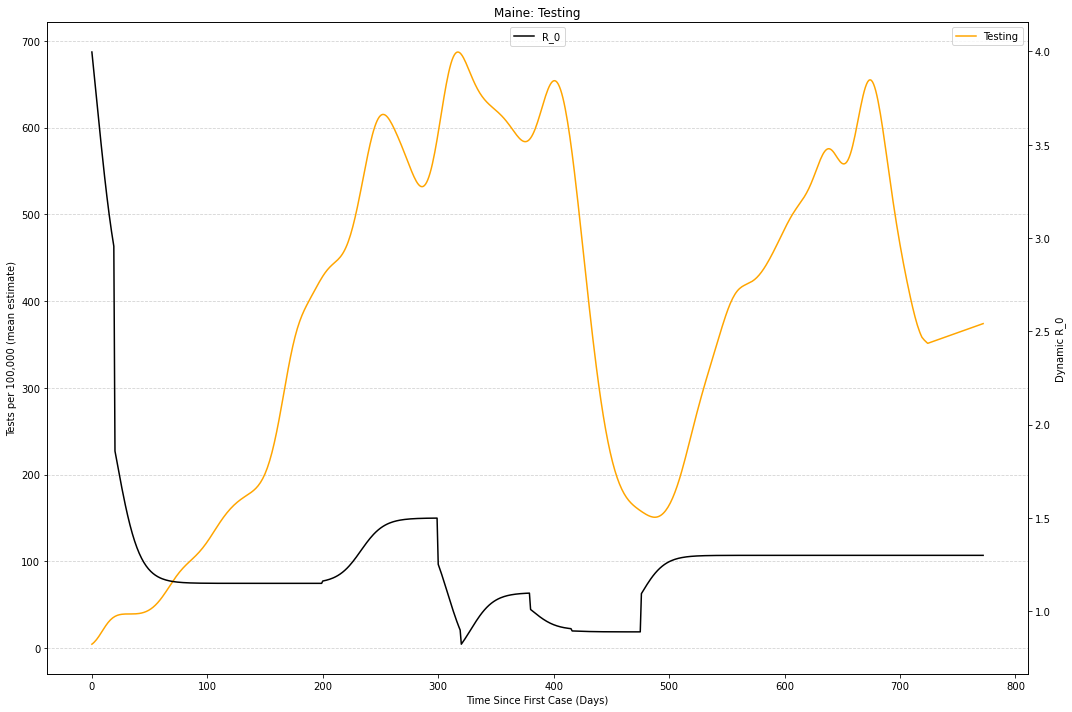

In [364]:
fig, ax = plt.subplots(figsize=(15,10))
ax2 = ax.twinx()
ax.set_title(state+': Testing')
ax.set_xlabel('Time Since First Case (Days)')
ax.plot(subset.index, subset['testing_mean'], color='orange')
ax2.plot(t, rt, color='black')
ax.set_ylabel('Tests per 100,000 (mean estimate)')
ax2.set_ylabel('Dynamic R_0')
ax.legend(['Testing'])
ax2.legend(['R_0'], loc='upper center')
ax.yaxis.grid(color='lightgray', linestyle='dashed')
plt.tight_layout()
plt.show()

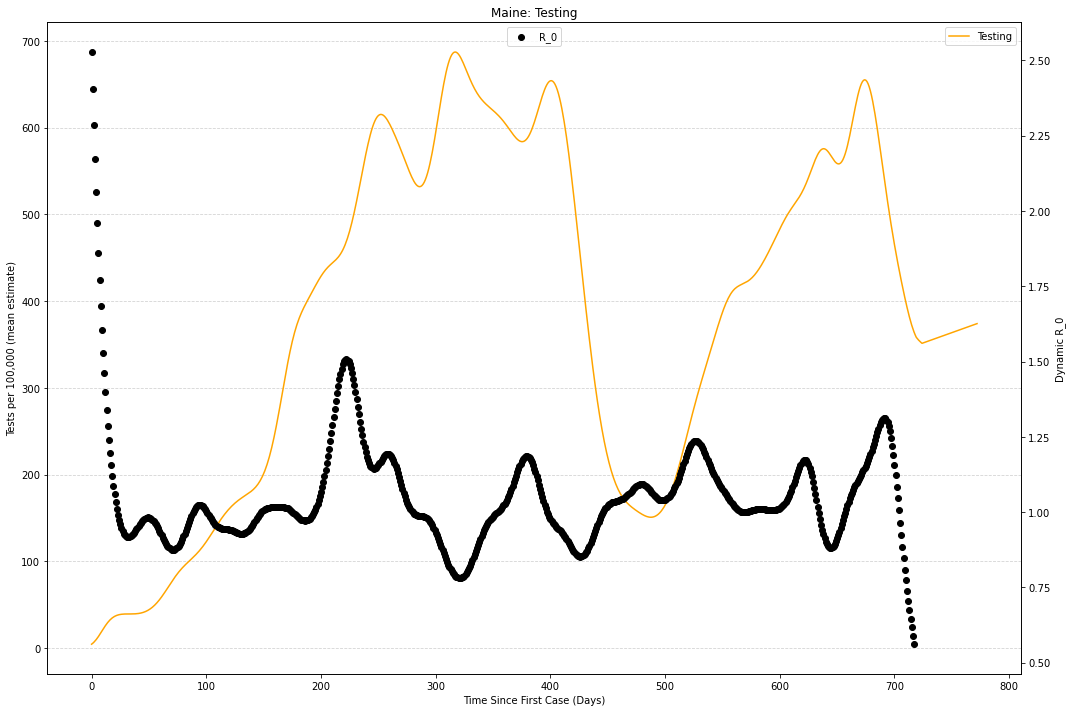

In [365]:

fig, ax = plt.subplots(figsize=(15,10))
ax2 = ax.twinx()
ax.set_title(state+': Testing')
ax.set_xlabel('Time Since First Case (Days)')
ax.plot(subset.index, subset['testing_mean'], color='orange')
#ax2.plot(t, rt, color='black')
ax2.scatter(estimates_state.index, estimates_state['Rt'], color='black')
ax.set_ylabel('Tests per 100,000 (mean estimate)')
ax2.set_ylabel('Dynamic R_0')
ax.legend(['Testing'])
ax2.legend(['R_0'], loc='upper center')
ax.yaxis.grid(color='lightgray', linestyle='dashed')
plt.tight_layout()
plt.show()


## Vaccination

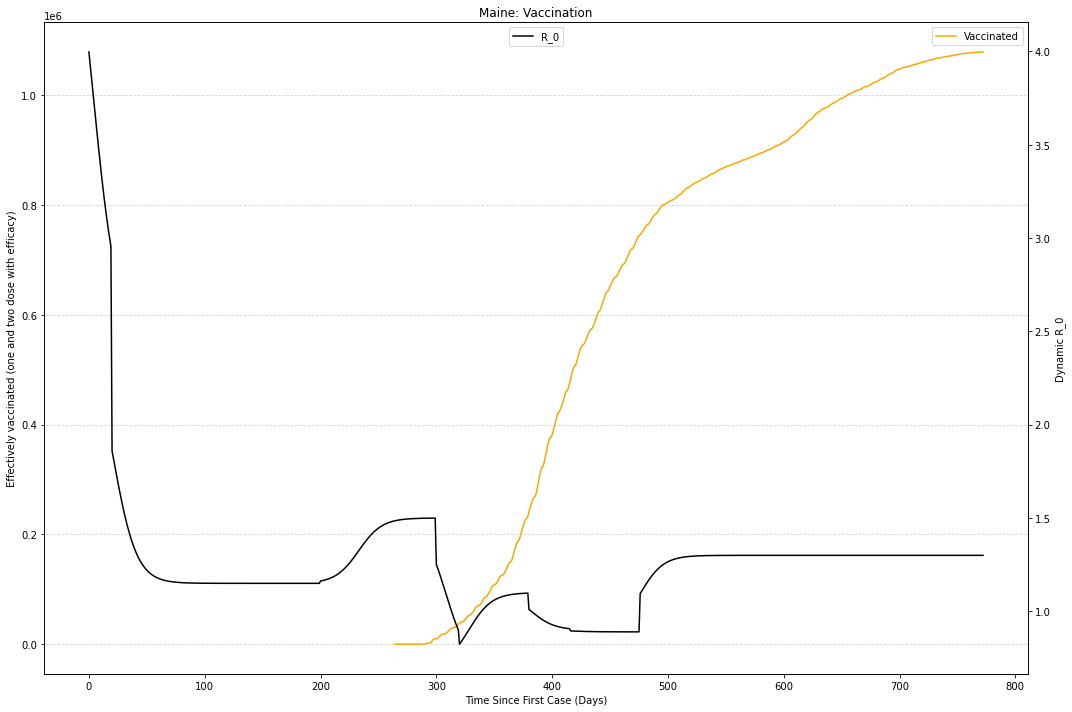

In [366]:
fig, ax = plt.subplots(figsize=(15,10))
ax2 = ax.twinx()
ax.set_title(state+': Vaccination')
ax.set_xlabel('Time Since First Case (Days)')
ax.plot(subset.index, subset['cumulative_all_effectively_vaccinated'], color='orange')
ax2.plot(t, rt, color='black')
ax.set_ylabel('Effectively vaccinated (one and two dose with efficacy)')
ax2.set_ylabel('Dynamic R_0')
ax.legend(['Vaccinated'])
ax2.legend(['R_0'], loc='upper center')
ax.yaxis.grid(color='lightgray', linestyle='dashed')
plt.tight_layout()
plt.show()




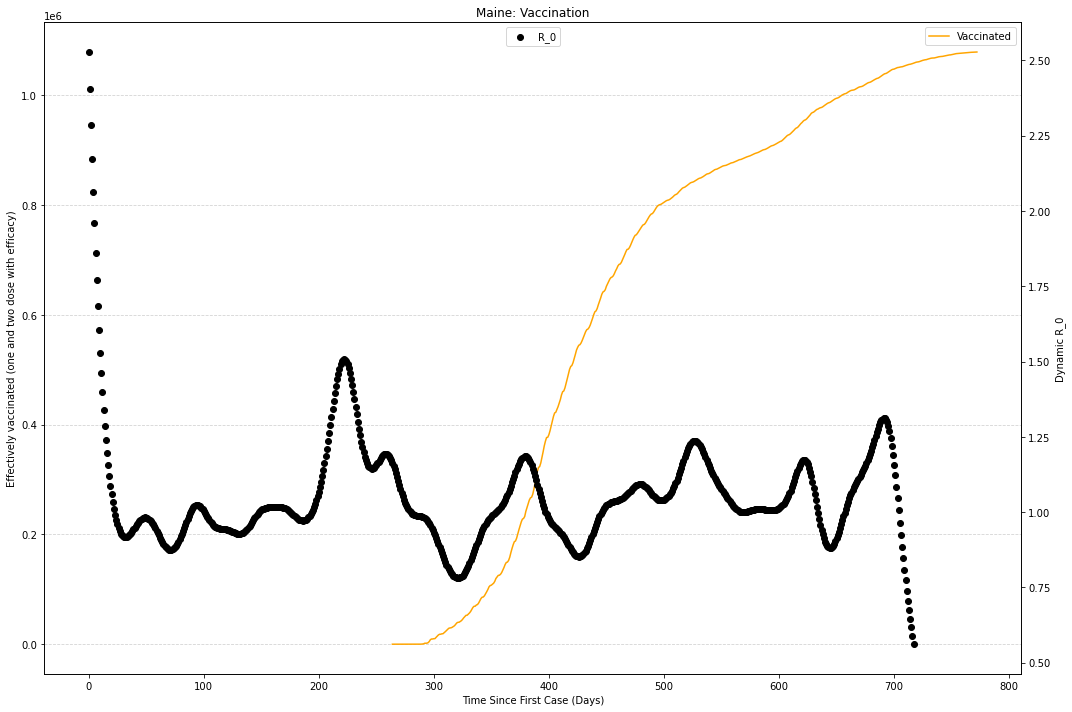

In [367]:
fig, ax = plt.subplots(figsize=(15,10))
ax2 = ax.twinx()
ax.set_title(state+': Vaccination')
ax.set_xlabel('Time Since First Case (Days)')
ax.plot(subset.index, subset['cumulative_all_effectively_vaccinated'], color='orange')
#ax2.plot(t, rt, color='black')
ax2.scatter(estimates_state.index, estimates_state['Rt'], color='black')
ax.set_ylabel('Effectively vaccinated (one and two dose with efficacy)')
ax2.set_ylabel('Dynamic R_0')
ax.legend(['Vaccinated'])
ax2.legend(['R_0'], loc='upper center')
ax.yaxis.grid(color='lightgray', linestyle='dashed')
plt.tight_layout()
plt.show()